# Building a Machine Learning Model to Predict Solubility

<div class="alert alert-block alert-info"> 
<h2>Overview</h2>

<strong>Questions:</strong>

* What is machine learning?

* How do machine learning models make predictions?

<strong>Objectives:</strong>

* Generate a cheminformatics data set using the RDKit library starting from a list of SMILES codes
* Create and train a random forest regression model and compare the performance to a linear regression model
* Create and train a random forest classification model
* Generate novel cheminformatics data to use in training a random forest classification  model

</div>

### Importing libraries
We will be using many libraries for today's lesson.  Be sure to run the cell below to import all necessary libraries.  

In [ ]:
import pandas as pd                 # for data manipulation
import seaborn as sns               # for data visualization
import matplotlib.pyplot as plt     # for data visualization
import numpy as np                  # for numerical operations
import sweetviz as sv               # for fast exploratory data analysis (eda)

from rdkit import Chem              # for calculating cheminformatics properties of molecules
from rdkit.Chem import Descriptors  # for determining chemical descriptors
from rdkit.Chem import Crippen      # for calculating logP (cLogP)
from rdkit.Chem import PandasTools  # for displaying molecules
PandasTools.RenderImagesInAllDataFrames(images=True) # Ensures molecules are rendered in the notebook

from sklearn.preprocessing import StandardScaler                             # for scaling the data
from sklearn.model_selection import train_test_split                         # for splitting the data into training and testing sets
from sklearn.model_selection import cross_val_score, KFold                   # for K-fold cross-validation
from sklearn.linear_model import LinearRegression                            # for creating a linear regression model
from sklearn.ensemble import RandomForestRegressor                           # for creating a random forest regression model
from sklearn.dummy import DummyRegressor                                     # for creating a base regressor to compare the model with
from sklearn.ensemble import RandomForestClassifier                          # for creating a random forest classification model
from sklearn.metrics import mean_squared_error, r2_score                     # for evaluating the regression model
from sklearn.metrics import accuracy_score, precision_score, recall_score    # for evaluating the classification model
from sklearn.pipeline import make_pipeline                                   # for building operational pipelines

## Predicting Solubility in Water

We will be combining the skills we learned in the RDKit lesson and the pandas and seaborn lesson to  **create a cheminformatics data set** from a machine-readable list of molecules. The goal is to use the provided molecules to calculate various chemical properties of each molecule and then predict the solubility of a molecule in water based on its chemical structure and properties using machine learning models. We will create a version of the [Delaney's solubility dataset](https://doi.org/10.1021/ci034243x).  We will then use this data set to build different types of machine learning models, including linear regression modles and random forest models.  

We will begin by creating a pandas dataset of molecules and their solubility.


In [ ]:
# Path to the list of molecules data file
data_path = "data/solubility-molecule-list.csv"

# Read the data into a DataFrame
df = pd.read_csv(data_path)

# Display the first few rows of the DataFrame
df.head()

The dataset contains the following columns:
- **Compound ID**: compound name in a range of formats
- **smiles**: SMILES string representation of each molecule
- **logS**: the solubility of the molecule in mol/L measured at 25 $\degree$ 𝐶 on a log scale

### Adding molecule objects to the data set using the SMILES strings

We already learned out to create RDKit molecule objects from SMILES strings in our prior lessons. 

#### The `.apply` function

When we are working with a lot of molecular data, we might have a whole column of SMILES strings that we need to use to make molecule objects.  Further, we would like to save those molecule objects as a new column in our pandas dataframe.  This is generally true; you often want to calculate a new column of data using an existing column in your data frame.  The way to accomplish this is to use the `.apply` method.  You access any exisiting column of your python dataframe, put `.apply()` and then in the parenthesis, give a python function that calculates the thing you want to calculate.  In the code below, we will take the column of SMILES strings and apply the `Chem.MolFromSmiles` function and save the results as a new column of the dataframe.

In [ ]:
# visualizing all the molecules in our data set
df['mol'] = df['smiles'].apply(Chem.MolFromSmiles)
df.head()

### Properties that affect solubility
As know from our prior lessons, RDKit molecule objects have a number of methods we can use to get more information about the molecule.  We are interested in creating a dataset that includes molecular properties that affect solubility, since we ultimately want to use those properties to predict the solubility of molecules.  Molecular properties we want to add to our data set include:
1. Molecular weight
2. The number of rotatable bonds
3. The Wildman-Crippen LogP value, which is a measure of hydrophobicity.  It describes a molecule's preference for an organic (lipophilic) phase versus an aqueous (hydrophilic) phase phase.
4. The aromatic ratio, which is defined as the number of heavy (non-hydrogen) aromatic atoms divided by the total number of heavy atoms.  
   
We can use the `.apply` function we learned about in our prior lessons to apply methods to our molecule objects and save the results in a new column.

<div class="alert alert-block alert-warning">
<h3>Exercise</h3>

For each property listed below, calculate the value of the property for every molecule in our dataset.  Add each property to your pandas dataframe as a new column.
1. Molecular weight (`Descriptors.MolWt`)
2. Number rotatable bonds (`Chem.rdMolDescriptors.CalcNumRotatableBonds`)
3. The LogP value (`Chem.Crippen.MolLogP`)

</div>

In [ ]:
# Your code goes here

### Calculating aromatic ratio

The final property we want for our dataset is the aromatic ratio.  Although there is not a function in RDKit that calculates this directly, we can calculate it by creating our own function that uses two existing RDKit functions to perform the calculation. Then we can use our new function and ``.apply`` to make a new column in our data set.

In [ ]:
## defining the function that will calculate the aromatic proportion

def aromatic_calc(mol):
    prop_aromatic = len(mol.GetAromaticAtoms())/mol.GetNumAtoms()
    return prop_aromatic

In [ ]:
#Adding to the dataset
df['aromatic_ratio'] =df['mol'].apply(aromatic_calc)
df.head()

### Calculating solubility in water (g per 100 mL)

Although logS is one way to describe solubility, another common definition in  applications such as water purification is grams of compound soluble in 100 mL of water. Because we already have both logS and the molecular weight for each compound, it is straightforward to calculate the solublity value as g / 100 mL of water. We will achieve this with 3 calculations in one: (1) convert logS to mol/L, (2) use molecular weight to convert this to g / L, and (3) convert to g / 100 mL of water.

$$
Solubility \frac{g}{ 100 mL} = 10^{logS} \hspace{2mm} \frac{mole}{L} \hspace{5mm} {\rm x} \hspace{5mm} Molecular Weight \hspace{2mm} \frac{g}{mole} \hspace{5mm} {\rm x} \hspace{5mm} \frac{1 L}{ 10 x 100 mL} 
$$

### Defining molecules as insoluble or soluble in water.
A common working definition for "water soluble" is having a solubility greater than 1 g per 100 mL. After calculating
solubility, we will assign each compound a value of "0" for not soluble in water or "1" for soluble in water.

In [ ]:
# Convert logS (mol/L) to g/100 mL
df["solubility"] = (10 ** df["logS"] * df["mol_weight"]) / 10

# Binary classification
df["soluble"] = (df["solubility"] > 1.0).astype(int)

df.head()

### Other calculations RDKit can perform

There are many other properties of molecules that RDKit can caculate.  In general, the methods in RDKit are organized into modules baesd on the type of property they calculate.  For instance, in some of the examples above, we used methods from the 
[`Descriptors` module](https://www.rdkit.org/docs/source/rdkit.Chem.Descriptors.html) and the [`rdMolDescriptors` module](https://www.rdkit.org/docs/source/rdkit.Chem.rdMolDescriptors.html).  You can click on either of those links to see the full list of the different properties you can access. 

### Exploratory Data Analysis (EDA) of the data set

The first step in building a machine learning model, after deciding what we want to predict, is to perform exploratory data analysis (EDA) on raw data. The EDA is crucial for data preprocessing pipelines as it helps us understand the nature of our data, identify the key patterns and relationships, and detect anomalies. The EDA involves summarizing the main characteristics of the data, often using visual methods. 

Loading the data into a Pandas DataFrame provides a convenient way to perform EDA.  We will use SweetViz, an EDA library, to verify the data we generated has no missing values and has the expected value distributions.  The molecule images, however, will cause an error. So we will create a version of the DataFrame called df_nomol with the 'mol' column dropped. 

In [ ]:
# dropping the mol columns

df_nomol = df.drop(columns = ['mol'])
df_nomol.head()

In [ ]:
# Analyse Dataset
report = sv.analyze(df_nomol)

# View and Save
report.show_notebook()

### Key Metrics to Consider in EDA

#### Checking for Missing Values

Since the data is already preprocessed, the number of Missing values for all features should be zero. The experimentally measured solubility in the last column logS is the target variable and the remaining columns are the features.

#### Statistical Summary of the Data
We also see a statistical summary of each numerical features in our dataset. The provided statistics include the value counts, mean, standard deviation, minimum, 25th percentile, median, average, 75th percentile, and maximum values for each feature.

This information is extremely useful for understanding the data and the distribution of the features. It helps in identifying anomalies in the data or if our data requires any preprocessing. 

#### Balance in the data
For categorical variables such as soluble, model  performance is best when each class (insoluble versus soluble) is represented equally. But unbalanced data is common in real-world data sets. Models often favor predicting the majority class as statistically this produces the "best" results. The minority class(es) are also usually important and so attention must be paid to building models that predict all classes well.

#### Correlation of Features with Target Variable
The correlation matrix between the features and the target variable provides insights into the relationships between the features and the target variable(s). You may need to click on the "Associations" button in order to see the correlation matrix.

A correlation value close to 1 indicates a strong positive relationship, while a correlation value close to -1 indicates a strong negative relationship. A correlation value close to 0 indicates no relationship between the features.

The coloring scheme makes it easy to uncover the relationships between the features. The darker the color, the stronger the correlation. The diagonal line represents the correlation of each feature with itself, which is always 1. The blue color indicates a positive correlation, while the red color signifies a negative correlation (based on the provided key).

<div class="alert alert-block alert-warning"> 
<h3>Exercise</h3>
    If you haven't already, click on the Associations button to display the correlation plot.  <br><br>
    Based on the correlation plot, which feature is most strongly correlated with the logS value? And is it a negative or positive correlation?
    <br><br>
    We calculated the solubility value using the logS value. Would you expect these values to be highly correlated?
</div>

## Splitting the Data Into Training and Testing Sets for predicting logS

Once we have a good understanding of the data, we can move on to the next step, which is splitting the data into a training set and a testing set. The training set is used to train the model, and the testing set is used to evaluate the model's performance. This process allows you to test the model's accuracy on unseen data and ensures that the model can generalize well to new data.

It is extremely important to split the data first and then perform subsequent feature engineering steps such as creating new features, transforming data formats, selecting the most useful features and addressing any missing value. Feature engineering prior to splitting the data can cause a <b>data leakage</b> problem, allowing the model to "see" the testing data in the training phase. This violates our intention to treat the test data as a good representative sample of the real-world data. Data leakage leads to a model that performs well in training and testing but that performs poorly when given novel data.

There are some columns we will need to remove from the dataframe we generated if we are predicting logS. Since the <b>solubility</b> column is a calculation based directly on logS, using it to predict logS would be equivalent to  providing logS to the model for predicting logS. The model would be very good at predicting the values, but would not be able to predict well for data outside of the original data set. This is also true for the <b>soluble</b> column.

To create our training and testing data sets, we will use the ``train_test_split`` function from the ``sklearn.model_selection`` module to split the data. The training set will be used to train the model, while the testing set will be used to evaluate the model's performance.

Useful information about the train test split process:
- ``x`` generally denotes the input variables (the data the model will use to make predictions)
- ``y`` is often used for target variable (what we are trying to predict)
- ``test_size`` is used to assign the percentage of the data set aside for the testing set
- ``random_state`` controls the random number generator used to shuffle the data before splitting it. In other words, it ensures that the same randomization is used each time you run the code, resulting in the same splits of the data. This is especially useful if you want to compare the performance of multiple models. Note that although a random state makes it easy to compare models, it also biases how the data is handled while training the model. A best practice is to set a random state when comparing models, but to not use a random state for a model that is going into production. You can use any value for the random state, with common values being 1 or 42 (which means any AI-assistance with coding will often use 1 or 42 even if a random state does not need to be set).
- ``shuffle = True`` ensures that the data is split randomly.

In [ ]:
# Create the feature matrix (X), feature vector (x), and the target vector (y)
X = df.drop(columns=['logS','solubility', 'soluble'])

# We are going to start by picking just one feature, our most highly correlated thing
x = X["clogP"]
y = df['logS']

# Split the data into training and testing sets (80% training, 20% testing)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123, shuffle=True)

# Reshape the data into 2D arrays of shape (n_samples, 1)
# (if working with only one input feature)
x_train = x_train.values.reshape(-1,1)
x_test = x_test.values.reshape(-1,1)
y_train = y_train.values.reshape(-1,1)
y_test = y_test.values.reshape(-1,1)

# Display the shapes of the training and testing sets
x_train.shape, x_test.shape, y_train.shape, y_test.shape

<div class="alert alert-block alert-info">
    <b>Note</b>
    Note the use of the <b>x</b> vector in the <b>train_test_split</b> function as initially we will train a model using only one input feature.<br> If we instead want to use all the available features we would need to use the <b>X</b> matrix that we have defined.  This is something we will use later.
</div>

## Feature Engineering

Once we have a good understanding of the data, we can move on to the next step, which is feature engineering. Feature engineering is the process of transforming the raw data into a format that is suitable for machine learning models. Feature engineering often involves creating new features, selecting the most important features, and transforming the existing features in order to improve the model's performance.

After splitting our data, we need to scale our train and test features. Scaling is a crucial step in the data preprocessing pipeline as it ensures that all features have the same scale, since many machine learning models are sensitive to the scale of the input features. For example, in our dataset the values for the number of rotatable bonds ranges from 0 to 23 while the molecular weight values go as high as 781. If we left these data with these ranges, the molecular weight values would impact the final predictions more than the rotatable bonds, even if that was not the best feature to weight heavily for the prediction. Converting the data to a single standard scale is a required step, with common transformations adjusting all the data to a range between 0 and 1 or between -1 and 1. We will use the ``StandardScaler`` from the ``sklearn.preprocessing`` module to scale our features. ``StandardScaler`` transforms the data in such a manner that it has mean value of 0 and a standard deviation value of 1.

In [ ]:
# Create the standard scaler object
scaler = StandardScaler()

# Fit and transform the training feature vector x_train
x_train_scaled = scaler.fit_transform(x_train)

# Transform the test feature vector x_test
x_test_scaled = scaler.transform(x_test)

# Make sure the training data is scaled correctly
print(f" Training feature mean: {x_train_scaled.mean():.5f}")
print(f" Training feature standard deviation: {x_train_scaled.std():.5f}\n")

# Print the scaler statistics on the test data
print(f" Testing feature mean: {x_test_scaled.mean():.5f}")
print(f" Testing feature standard deviation: {x_test_scaled.std():.5f}")

<div class="alert alert-block alert-info">
    <b>Reminder:</b>
    It is extremely important to split the data first and then fit the scaler on the training data, only. Fitting the scaler on the entire data and then splitting it causes the <b>data leakage</b> problem which violates our intention to treat the test data as a good representative sample of the real-world data.  
</div>

## Building and Training a Linear Regression Model

The next step after the data preparation is to build and train our model. We will build a simple linear regression model which focuses on the relationship between a single feature (``cLogP``) and the target variable (``logS``). 

<div class="alert alert-block alert-warning"> 
<h3>Discussion</h3>
    What is the reason behind choosing <b>cLogP</b> as our main feature in the linear regression model?
</div>

#### Judging Model Performance with a Dummy Regressor

In order to evaluate the performance of our model, we can first create a dummy "model" using the ``DummyRegressor`` class from the ``sklearn.dummy`` module. This class provides a simple way to create a model that calculates the mean value of the target feature and predicts this mean value for each observation. The ``fit`` method is used to train the model on the training data. Once the model is trained, we can use the ``predict`` method to make predictions on the test data. Note that the ``DummyRegressor`` is not for solving real problems! The value of the ``DummyRegressor`` is to provide a baseline set of values for the evaluating the error (such as mean squared error or R-squared). An true machine learning model trained with the same data should have much better performance than the ``DummyRegressor``.

In [ ]:
# Create a dummy model using the mean value of the target property
dummy_model = DummyRegressor(strategy="mean")

# Fit the model to the training data
dummy_model.fit(x_train_scaled, y_train)

# Make predictions on the testing data
y_pred_dummy = dummy_model.predict(x_test_scaled)

# Calculate the performance metrics and store them in a DataFrame
results = pd.DataFrame({
    "Coefficients": [np.array(dummy_model.constant_)],   # the regression coefficient
    "MSE": mean_squared_error(y_test, y_pred_dummy),     # the mean squared error
    "R2": r2_score(y_test, y_pred_dummy)                 # the coefficient of determination
}, index=["Dummy"])
                            

# Set the formatting style
results.style.format(
    {
        "MSE": "{:.3f}",
        "R2": "{:.2f}"
    }
)

<div class="alert alert-block alert-warning"> 
<h3>Discussion</h3>
    Do we want to maximize or minimize the MSE value? What about R2? 
   <br>
</div>

### Linear Regression Model

Now let's build and train our single-feature input linear regression model.  We will use the ``LinearRegression`` class from the ``sklearn.linear_model`` module to create the model.   We already selected `cLogP` for our one feature and `logS` for our target variable when we did the test train split above.

In [ ]:
# Create a simple linear regression model
simple_reg_model = LinearRegression()

# Fit the model to the training data
simple_reg_model.fit(x_train_scaled, y_train)

# Make predictions on the test data
y_pred_simple = simple_reg_model.predict(x_test_scaled)

# Calculate the performance metrics
simple_model_results = pd.DataFrame({
    "Coefficients": [np.array(simple_reg_model.coef_)],   # the regression coefficient
    "MSE": mean_squared_error(y_test, y_pred_simple),     # the mean squared error
    "R2": r2_score(y_test, y_pred_simple)                 # the coefficient of determination
}, index=["Simple-Linear-Regression"])

# Store the results into results DataFrame
results = pd.concat([results, simple_model_results])
results

<div class="alert alert-block alert-warning"> 
<h3>Discussion</h3>
    Which model is best at predicting the value of logS? Make sure to use the relevant metrics for your evaluation.
</div>

### Visualizing Model Performance

We are now going to make a graph with matplotlib to visualize our model's performance.  We will plot the test data as blue dots, the dummy regressor as a green line, and the linear regression as a red line.

In [ ]:
# Create a plot object 
fig, ax = plt.subplots(figsize=(5, 5))

# Plot the test data
ax.scatter(x_test_scaled, y_test, color='blue', label='Test Data')

# Plot the simple linear regression model
ax.plot(x_test_scaled, y_pred_simple, color='red', label='Simple Linear Regression')

# Plot the baseline model
ax.plot(x_test_scaled, y_pred_dummy, "g--", label="Dummy")

# Create the legends
fig.legend(facecolor='white')

# Show the plot
plt.show()

# Building a multifeature linear regression

## Splitting the data

Using the ``cLogP`` feature with highest correlation with the target variable ``logS`` is a good starting point. However, we can improve our model by including other features that show some correlation with the target variable.  This is the idea of a multi-linear regression.

Let's build a multiple linear regression model using all the features in our dataset. The process is very similar to building a single-feature linear regression model: Once again, we need to scale the data, train the model on the scaled training data using the ``fit`` method, and make predictions on the test data using the ``predict`` function.

We will again split the data into train and test prior to doing any other data cleaning or engineering, to prevent data leakage between the training and testing data. We will use the ``train_test_split`` function from the ``sklearn.model_selection`` module to split the data into training and testing sets. The training set will be used to train the model, while the testing set will be used to evaluate the model's performance. We will also use a ``random_state `` again, so the data is the same when comparing different models. 

We will drop the target vector 'logS', and also the 'smiles', 'mol', 'Compound ID', 'solubility', and 'soluble' columns as we do not want the model to use those to predict the solubility.

In [ ]:
# Create the feature matrix (x) and target vector (y)
X = df.drop(columns=['logS', 'smiles', 'mol', 'Compound ID', 'solubility', 'soluble'])
y = df['logS']

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, shuffle=True)

# Display the shapes of the training and testing sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape

<div class="alert alert-block alert-info">
    <b>Note</b>
    Note the usage of <b>X</b> matrix instead of <b>x</b> vector in the <b>train_test_split</b> function, since now we want to use multiple features to predict the target variable.
</div>

### Feature engineering

After splitting our data, we need to scale our training (and test) features. Scaling is a crucial step in the data preprocessing pipeline as it ensures that all features have the same scale as many machine learning models are sensitive to the scale of the input features. We will use the ``StandardScaler`` from the ``sklearn.preprocessing`` module to scale our features. Note that a Random Forest model does not require data scaling, as it is a tree-based model and so different scales will not affect model performance. We will still scale the data, however, so we can also build a linear regression model and compare the performance of two models. 

In [ ]:
# Create the standard scaler object
scaler = StandardScaler()

# Fit and transform the training feature vector X_train
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test feature vector X_test
X_test_scaled = scaler.transform(X_test)

# Make sure the training data is scaled correctly
print(f" Training feature mean: {X_train_scaled.mean():.5f}")
print(f" Training feature standard deviation: {x_train_scaled.std():.5f}\n")

# Print the scaler statistics on the test data
print(f" Testing feature mean: {X_test_scaled.mean():.5f}")
print(f" Testing feature standard deviation: {X_test_scaled.std():.5f}")

<div class="alert alert-block alert-info">
    <b>Reminder:</b>
    It is extremely important to split the data first and then fit the scaler on the training data only. Fitting the scaler on the entire data and then splitting it can cause a <b>data leakage</b> problem which violates our intention to treat the test data as a good representative sample of the real-world data.  
</div>

Now we will build the multi-linear regression model.

In [ ]:
# Create a linear regression model
multi_feature_model = LinearRegression()

# Fit the model to the training data
multi_feature_model.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred_linear_multi = multi_feature_model.predict(X_test_scaled)

# Calculate the performance metrics and store them in a DataFrame
results = pd.DataFrame({
    "MSE": mean_squared_error(y_test, y_pred_linear_multi),     # the mean squared error
    "R2": r2_score(y_test, y_pred_linear_multi)                 # the coefficient of determination
}, index=["Multi-Linear-Regression"])
                            

# Set the formatting style
results.style.format(
    {
        "MSE": "{:.3f}",
        "R2": "{:.2f}"
    }
)

<div class="alert alert-block alert-warning"> 
<h3>Discussion</h3>
    Did model performance improve by using a multi-linear regression over the linear model?  What metrics indicate this?
</div>

## Building and Training a Random Forest Regression Model

### What is a random forest model?
There are many other kinds of machine learning models besides linear regression models.  One type is 
a random forest regression model. A random forest is a decision tree model that uses a "forest" of multiple decision trees and randomly chooses which variables to use in each tree. Generally, each individual tree is not that good at making a prediction, but collectively the trees are quite good at making predictions. Note that each tree predicts an individual value and then a vote is taken (in the case of regression, an average of the predicted values) to determine the final predicted value.

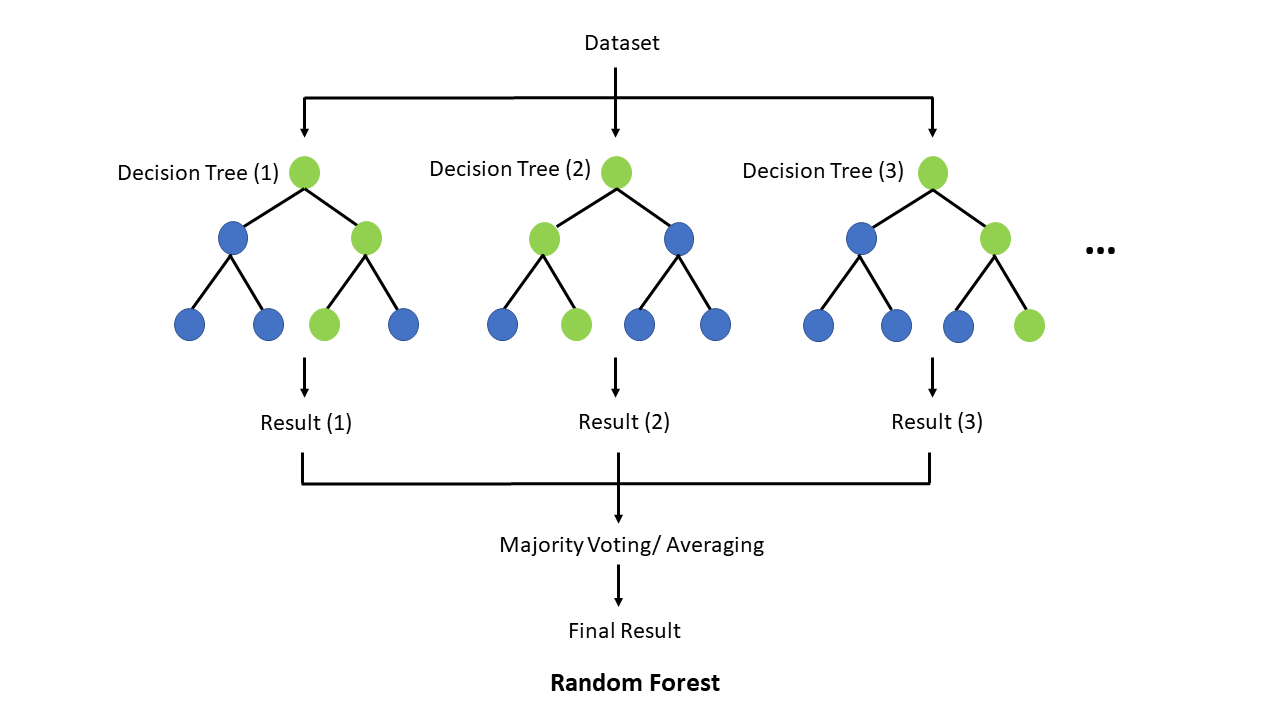

### Hyperparameters
Random forest models (and many other models) have hyperparameters that can be 'tuned' to opmitize model performance.The number of trees (``n_iterators``) can be specified, with a default value of 100 trees. Each tree also has a depth(``max_depth``) which specifies the maximum number of splits a tree can have, with the default value being no limit on the depth ('None'). Too few trees or trees that are too shallow results in a model that predicts poorly due to underfitting the data--the model is too simple to predict using train or test data. Too many trees or trees that are too deep results in a model that predicts poorly due to overfitting the data--the model is so complex it can predict using the original data extremely well but cannot predict using new data. The default values are a good starting place for most random forest models.

### Building and training a default random forest regression model
We will first build and train a random forest model that uses the default parameters. We will use the ``RandomForestRegressor`` class from the ``sklearn.ensemble`` module to create the model. 

In [ ]:
# Create a random forest regression model
default_rf_reg_model = RandomForestRegressor()

# Fit the model to the training data
default_rf_reg_model.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred_default_rf = default_rf_reg_model.predict(X_test_scaled)

# Calculate the performance metrics
default_rf_reg_model_results = pd.DataFrame({
    "MSE": mean_squared_error(y_test, y_pred_default_rf),     # the mean squared error
    "R2": r2_score(y_test, y_pred_default_rf)                 # the coefficient of determination
}, index=["Default_RF_Regression"])

# Store the results into results DataFrame
results = pd.concat([results, default_rf_reg_model_results])
results

<div class="alert alert-block alert-warning"> 
<h3>Discussion</h3>
    Which model better at predicting the value of logS?
</div>

### Another way to visualize model performance

Now we will make plots again to visualize our model performance.  Another way you can do this is to plot your model performance vs. the original data.  If your model predicted every data point correctly, this would give a straight line, the line y=x.  You can look at the scatter compared to the y=x line and get a sense of how well your model is performing.

In [ ]:
# Create a plot object
fig, ax = plt.subplots(figsize=(5, 5))

# Plot the test data
ax.scatter(y_test, y_test, color='blue', label='Test Data')

# Plot the simple linear regression model
ax.scatter(y_test, y_pred_default_rf, color='red', label='Random Forest Regression')

# Plot the multi-variable linear regression model
ax.scatter(y_test, y_pred_linear_multi, color='green', label="Multifeature Linear Regression")

# Create the legends
fig.legend(facecolor='white')

# Show the plot
plt.show()

## Building and Training a Random Forest Classification Model

### What is a classification model?
Classification models predict classes rather than a range of values. Classification models are very popular in many situations because the predictions are easy to understand.  A model that take an image and predicts if it is a dog or a cat is a popular example of a classification model.

For the data we have been working with, predicting if a compound is soluble or insoluble in water would be a relevant classification model. The model could predict "insoluble" versus "soluble", instead of predicting the numerical value of `logS`.  It is possible to build a multi-class classifier model with more than two classes, but these are more complex to build than a binary (two class) model. We will focus on a binary classification model.

### Creating the binary target
In order to predict a binary target, we need our data set to have a categorical variable as one of the features. This is a variable with only categories, or classes, even if those classes are represented as numbers. We added a column to our original dataframe called "soluble", one that labeled each molecule as either insoluble (0) or soluble (1). This will be the target variable for building our classification model. 

### Metrics for classification models
We have been using RMSE and R2 values, but these are not useful for classification models. Instead we will use the ``sklearn.metrics`` functions for ``accuracy_score``, ``precision_score`` and ``recall_score``. 

<b>Accuracy</b> measures the correct predictions out of the total number of predictions. This is useful, but can be misleading if the data set has much more of one class over the other. For example, if toxic molecules are only 1% of an entire data set the accuracy would be 0.99 even if every toxic molecule was incorrectly classified as non-toxic. 

<b>Precision</b> measures how many negative values are falsely labeled as positive. This is an important metric if the cost of a false positive is high, for example incorrectly identifying a molecule as toxic and removing it from a list of potential drug candidates. 

<b>Recall</b> measures the ability to find all positives and is important when the cost of false negatives is high, for example predicting that a compound is non-toxic when it is actually toxic. 

Frequently all three metrics are evaluated for classification models. Note that precision and recall are often inversely related, and so you may need to find a compromise between the two when building a classification a model. There are many other ``sklearn.metrics`` for classification models, which you can explore on the scikitlearn website.


<div class="alert alert-block alert-warning"> 
<h3>Discussion</h3>
    Is our dataset balanced (equal numbers in each class) for the <b>soluble</b> variable?
</div>

### Building and training a default random forest classification model
 We will now build and train a random forest classification model that uses the default parameters. We will use 
the ``RandomForestClassifier`` class from the ``sklearn.ensemble`` module to create the model. We will also need to create new target  for the classification model, as the regression model utilized logS as the target variable. We will also need to do the train-test split again, as the previous split we were using a different target variable.  We will not generate the single-feature x vector as we will want to use more than one feature for our classification model.



In [ ]:
# Preparing the training and testing data for the classification model

# Create the feature matrix (X_clf) and the target vector (y_clf)
X_clf = df.drop(columns=['Compound ID', 'smiles', 'logS','mol','solubility', 'soluble'])
y_clf = df['soluble']

# Split the data into training and testing sets (80% training, 20% testing)
X_clf_train, X_clf_test, y_clf_train, y_clf_test = train_test_split(X_clf, y_clf, test_size=0.2, random_state=123, shuffle=True)

# Display the shapes of the training and testing sets
X_clf_train.shape, X_clf_test.shape, y_clf_train.shape, y_clf_test.shape

<div class="alert alert-block alert-warning"> 
<h3>Discussion</h3>
    Why are we dropping the solubility and logS variables from the data used to train and test the classification model?
</div>

In [ ]:
# Scaling the classification data

# Create the standard scaler object
scaler = StandardScaler()

# Fit and transform the training feature matrix X_clf_train
X_clf_train_scaled = scaler.fit_transform(X_clf_train)

# Transform the test feature feature matrix X_clf_test
X_clf_test_scaled = scaler.transform(X_clf_test)

# Make sure the training data is scaled correctly
print(f" Training feature mean: {X_clf_train_scaled.mean():.5f}")
print(f" Training feature standard deviation: {X_clf_train_scaled.std():.5f}\n")

# Print the scaler statistics on the test data
print(f" Testing feature mean: {X_clf_test_scaled.mean():.5f}")
print(f" Testing feature standard deviation: {X_clf_test_scaled.std():.5f}")

In [ ]:
# Create a random forest classification model
default_rf_clf_model = RandomForestClassifier()

# Fit the model to the training data
default_rf_clf_model.fit(X_clf_train_scaled, y_clf_train)

# Make predictions on the test data
y_pred_default_rf_clf = default_rf_clf_model.predict(X_clf_test_scaled)

# Calculate the performance metrics
default_rf_clf_model_results = pd.DataFrame({
    "Accuracy": accuracy_score(y_clf_test, y_pred_default_rf_clf),     # the accuracy score
    "Precision": precision_score(y_clf_test, y_pred_default_rf_clf),   # the precision score
    "Recall": recall_score(y_clf_test, y_pred_default_rf_clf)          # the recall score
}, index=["Default_RF_Classifier"])

default_rf_clf_model_results



<div class="alert alert-block alert-warning"> 
<h3>Discussion</h3>
    Discuss how well the classification model performed. Were false positives an issue? False negatives? Your evaluation should be based on the metrics for model performance.
</div>

<div class="alert alert-block alert-warning">
<h3>Final Activity</h3>

For our final activity, we will run the Random Forest classification model again but with new features of your choice. Look through the RDkit documentation and find <b>two</b> additional molecular properties you believe will be relevant for predicting solubility in water. Add these to the existing dataframe. 

Using the code above as a guide, train a new classification regression model using data that includes your new features.  You might also consider dropping some previous features.  

To turn in today, prepare a short (less tha one page) lab report discussion your classification model.  What new features did you decide to add and/or delete compared to the original model?  Why did you think these models would be predictive of solubility?  Compare and contrast the performance of the original classification model with the model that utilized the two additional features.  Make sure you explain using the appropriate metrics.   

</div>

In [ ]:
# Your code goes here


***
### Bonus material: Hyperparameter tuning (optional and outside of class)

Our  Random Forest models all used the default hyperparameter settings. Tuning (optimizing) hyperparameter settings can improve model performance. Code is provided for a loop to try a range of hyperparameter settings with our random forest models. Although we don't have time to use them today, tools such as ``GridSearchCV`` and ``Optuna`` can be used help identify the best set of hyperparameters. This is something you may want to consider for your class project. Read more about each hyperparameter on the scikitlearn website.

In [ ]:
# Defining the values to test for the n_iterators and max_depth hyperparameters
trees = [50, 100, 300, 500, 1000]
depths = [1, 3, 5, 7, 9, 11]

## Defining lists to store results for each set of 
tree_count = []
tree_depth = []
tuned_rf_MSE = []
tuned_rf_R2 = []

for tree in trees:
    
    for depth in depths:
        
        # Create a random forest regression model
        tuned_rf_model = RandomForestRegressor(n_estimators = tree, max_depth = depth)

        # Fit the model to the training data
        tuned_rf_model.fit(x_train_scaled, y_train)

        # Make predictions on the test data
        y_pred_tuned_rf = tuned_rf_model.predict(x_test_scaled)

        # Storing the results in lists
        tree_count.append(tree)
        tree_depth.append(depth)
        tuned_rf_MSE.append(mean_squared_error(y_test, y_pred_tuned_rf))
        tuned_rf_R2.append(r2_score(y_test, y_pred_tuned_rf))
        
        
# Create a DataFrame from the lists of results
results_df = pd.DataFrame(
    {'Number of trees': tree_count,
     'Max depth': tree_depth,
     'MSE': tuned_rf_MSE,
     'R2': tuned_rf_R2
    })

# display the results DataFrame
results_df